
=== SDSS J125637.13-022452.4 ===
Hα observada: 6524.85 ± 0.21 Å
Velocidad radial: -1733.54 ± 9.47 km/s


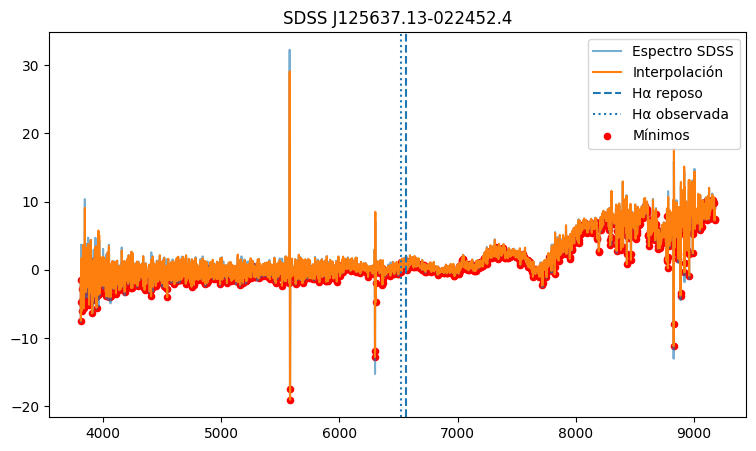


=== SDSS J102915+172927 ===
Hα observada: 6569.39 ± 0.10 Å
Velocidad radial: 300.97 ± 4.75 km/s


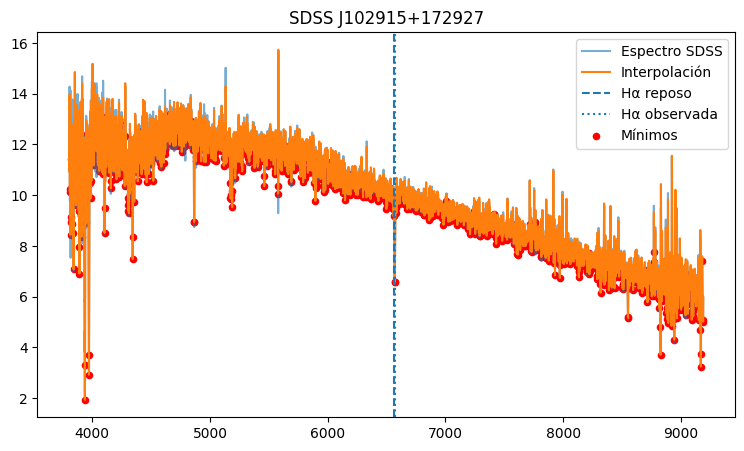

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord
from astroquery.sdss import SDSS

LAMBDA_REST = 6562.8 * u.AA   # Hα
VENTANA_A = 50.0
NUM_PUNTOS_INTERP = 5000

def gaussiana(x, A, mu, sigma, B):
    return A * np.exp(-(x - mu)**2 / (2.0 * sigma**2)) + B

def extract_lambda_flux(hdul):
    data = hdul[1].data
    lam = 10**data["loglam"] * u.AA
    flux = data["flux"]
    return lam.value, flux

def detect_minima(lam, flux):
    d1 = np.gradient(flux, lam)
    d2 = np.gradient(d1, lam)
    mins = []
    for i in range(1, len(lam)-1):
        if (d1[i-1] < 0 and d1[i+1] > 0) and d2[i] > 0:
            mins.append((lam[i], flux[i]))
    return np.array(mins)

def analizar(coord, nombre):
    xid = SDSS.query_region(coord, spectro=True, radius=2*u.arcmin)
    if xid is None or len(xid)==0:
        print(f"No hay espectro SDSS para {nombre}")
        return
    spec = SDSS.get_spectra(matches=xid[0:1])[0]
    lam, flux = extract_lambda_flux(spec)

    # Ordenar e interpolar
    order = np.argsort(lam)
    lam = lam[order]; flux = flux[order]
    cs = CubicSpline(lam, flux)
    lam_f = np.linspace(lam.min(), lam.max(), NUM_PUNTOS_INTERP)
    flux_f = cs(lam_f)

    # Detectar mínimos
    mins = detect_minima(lam_f, flux_f)

    # Buscar en ventana Hα
    lam_cand = LAMBDA_REST.value
    if len(mins) > 0:
        mask = (mins[:,0] > LAMBDA_REST.value-VENTANA_A) & (mins[:,0] < LAMBDA_REST.value+VENTANA_A)
        if np.any(mask):
            lam_cand = mins[mask][np.argmin(mins[mask][:,1]),0]

    # Ajuste gaussiano
    mask_fit = (lam_f > lam_cand-8) & (lam_f < lam_cand+8)
    x, y = lam_f[mask_fit], flux_f[mask_fit]
    p0 = [-0.5, lam_cand, 1.0, np.median(y)]
    popt, pcov = curve_fit(gaussiana, x, y, p0=p0)
    mu, mu_err = popt[1], np.sqrt(np.diag(pcov))[1]

    lambda_obs = mu*u.AA
    v_kms = (c.to(u.km/u.s).value)*(lambda_obs.value-LAMBDA_REST.value)/LAMBDA_REST.value
    sigma_v = (c.to(u.km/u.s).value/LAMBDA_REST.value)*mu_err

    # Resultados
    print(f"\n=== {nombre} ===")
    print(f"Hα observada: {lambda_obs.value:.2f} ± {mu_err:.2f} Å")
    print(f"Velocidad radial: {v_kms:.2f} ± {sigma_v:.2f} km/s")

    # Gráfico
    plt.figure(figsize=(9,5))
    plt.plot(lam, flux, alpha=0.6, label="Espectro SDSS")
    plt.plot(lam_f, flux_f, label="Interpolación")
    plt.axvline(LAMBDA_REST.value, ls="--", label="Hα reposo")
    plt.axvline(lambda_obs.value, ls=":", label="Hα observada")
    if len(mins)>0: plt.scatter(mins[:,0], mins[:,1], color="red", s=20, label="Mínimos")
    plt.legend(); plt.title(nombre); plt.show()

# =====================
# Ejecutar para 2 estrellas de SDSS
# =====================
coord_sdss1 = SkyCoord(ra=194.15471*u.deg, dec=-2.41456*u.deg, frame="icrs")  # SDSS J125637.13−022452.4
coord_sdss2 = SkyCoord(ra=157.31312*u.deg, dec=17.49083*u.deg, frame="icrs")  # SDSS J102915+172927

analizar(coord_sdss1, "SDSS J125637.13-022452.4")
analizar(coord_sdss2, "SDSS J102915+172927")
